In [1]:
from google.colab import drive
drive.mount ('/content/drive')

Mounted at /content/drive


In [2]:
!pip install -q -U keras-tuner

     |████████████████████████████████| 71kB 4.0MB/s 


In [3]:
# Import required packages, libraries and classes for the project

import numpy as np
np.random.seed(1)

import pandas as pd
import matplotlib.pyplot as plt
from keras.models import Sequential, load_model
from keras.layers.core import Dense
from keras.layers.recurrent import LSTM
from keras import optimizers
from keras.callbacks import EarlyStopping
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from math import sqrt
import datetime as dt
import time
import keras
plt.style.use('default')
from keras.layers import Dense, Dropout
import kerastuner as kt

### Data Preprocessing

In [4]:
# Load the Dataset
df = pd.read_csv("/content/drive/My Drive/stockQFLS.csv",parse_dates = True,index_col=0)
df.head()

,Open,High,Low,Volume,SMA,EMA,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH,STOCHD,Close
Date,,,,,,,,,,,,,,,
2014-06-15,18.357,18.434,18.136,931720.0,18.078095,18.172928,0.552,48.683736,-0.697586,-0.060299,18.06710,-1.514221e+06,62.222222,57.805213,18.221
2014-06-16,18.145,18.179,17.898,982840.0,18.084190,18.168121,0.314,45.079524,-1.895735,-0.072873,18.07095,-1.509559e+06,44.773663,62.716049,18.009
2014-06-17,17.847,18.417,17.847,1220000.0,18.100762,18.184033,0.204,49.158841,-1.333765,-0.066277,18.08795,-1.619076e+06,66.419753,72.522678,18.272
2014-06-18,18.272,18.680,18.264,668690.0,18.112524,18.175237,0.094,51.311048,-1.541096,-0.083672,18.09220,-1.904605e+06,76.954733,72.963405,18.400
2014-06-19,18.349,18.485,18.196,488820.0,18.126238,18.152760,0.068,48.757124,-0.322299,-0.117691,18.09815,-2.017427e+06,74.193548,64.516129,18.247


In [5]:
# Correlation Matrix
df.corr()['Close']

Open       0.998327
High       0.999250
Low        0.999016
Volume     0.108382
SMA        0.986210
EMA        0.989516
MOM        0.109056
RSI        0.163357
ROC        0.147149
MACD       0.223851
BB         0.986997
CHAIKIN    0.187980
STOCH      0.059589
STOCHD     0.061267
Close      1.000000
Name: Close, dtype: float64

In [6]:
# Extracting the features for the LSTM model
series = df[["Close",	"MOM",	"RSI",	"ROC",	"MACD",	"BB",	"CHAIKIN",	"STOCH"]]
print(series.shape)
series.head()

(1461, 8)


,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,18.221,0.552,48.683736,-0.697586,-0.060299,18.06710,-1.514221e+06,62.222222
2014-06-16,18.009,0.314,45.079524,-1.895735,-0.072873,18.07095,-1.509559e+06,44.773663
2014-06-17,18.272,0.204,49.158841,-1.333765,-0.066277,18.08795,-1.619076e+06,66.419753
2014-06-18,18.400,0.094,51.311048,-1.541096,-0.083672,18.09220,-1.904605e+06,76.954733
2014-06-19,18.247,0.068,48.757124,-0.322299,-0.117691,18.09815,-2.017427e+06,74.193548


In [7]:
# Normalisation
sc_X = StandardScaler()
series.iloc[:,1:] = sc_X.fit_transform(series.iloc[:,1:])
sc_y = StandardScaler()
series[['Close']] = sc_y.fit_transform(series[['Close']])
series

/usr/local/lib/python3.6/dist-packages/pandas/core/indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pa

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2014-06-15,0.730724,0.729997,-0.168818,-0.148898,-0.244816,0.697941,-0.818081,0.276749
2014-06-16,0.672698,0.406700,-0.467349,-0.309258,-0.289363,0.699004,-0.814710,-0.287813
2014-06-17,0.744684,0.257277,-0.129466,-0.234044,-0.265996,0.703697,-0.893897,0.412563
2014-06-18,0.779719,0.107854,0.048798,-0.261793,-0.327622,0.704870,-1.100350,0.753431
2014-06-19,0.737841,0.072536,-0.162739,-0.098669,-0.448137,0.706513,-1.181926,0.664091
...,...,...,...,...,...,...,...,...
2020-05-03,0.144710,0.143172,-1.285596,-0.809563,-0.416153,0.174658,-0.394832,-0.072488
2020-05-04,0.117339,0.007333,-1.806088,-0.858576,-0.457685,0.188737,-0.545255,-0.996940
2020-05-05,0.128287,0.007333,-1.714210,-0.744942,-0.472662,0.203368,-0.622954,-0.981533


In [8]:
series.tail()

,Close,MOM,RSI,ROC,MACD,BB,CHAIKIN,STOCH
Date,,,,,,,,
2020-05-03,0.144710,0.143172,-1.285596,-0.809563,-0.416153,0.174658,-0.394832,-0.072488
2020-05-04,0.117339,0.007333,-1.806088,-0.858576,-0.457685,0.188737,-0.545255,-0.996940
2020-05-05,0.128287,0.007333,-1.714210,-0.744942,-0.472662,0.203368,-0.622954,-0.981533
2020-05-06,0.111865,-0.033419,-2.050240,-0.866926,-0.497913,0.216894,-0.678251,-1.696057
2020-05-07,0.109128,-0.087754,-2.107195,-0.755352,-0.504516,0.229731,-0.649419,-1.736501


In [9]:
# Train/Test Data Split
train_start = dt.date(2014,5,15)
train_end = dt.date(2020,3,1)
train_data = series.loc[train_start:train_end]

test_start = dt.date(2020,3,2)
test_end = dt.date(2020,6,14)
test_data = series.loc[test_start:test_end]

print(train_data.shape,test_data.shape)

(1412, 8) (49, 8)


In [10]:
train = train_data.values
val = test_data.values

In [11]:
# Setting up an Early Stopping function
earlystop = EarlyStopping(monitor='val_loss', min_delta=0.0001, patience=80,  verbose=1, mode='min')
callbacks_list = [earlystop]
RMSE = keras.metrics.RootMeanSquaredError()

In [12]:
#Build and train the model
def fit_model(train,val,timesteps,lr,batch,epochs,dropout,units):
    X_train = []
    Y_train = []
    X_val = []
    Y_val = []
    hl = units
    # Loop for training data
    for i in range(timesteps,train.shape[0]):
        X_train.append(train[i-timesteps:i])
        Y_train.append(train[i][0])
    X_train,Y_train = np.array(X_train),np.array(Y_train)
  
    # Loop for val data
    for i in range(timesteps,val.shape[0]):
        X_val.append(val[i-timesteps:i])
        Y_val.append(val[i][0])
    X_val,Y_val = np.array(X_val),np.array(Y_val)
    
    # Adding Layers to the model
    model = Sequential()
    model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))
    for i in range(len(hl)-1):        
        model.add(LSTM(hl[i],activation = 'relu',return_sequences = True))
    model.add(LSTM(hl[-1],activation = 'relu'))
    model.add(Dropout(dropout))
    model.add(Dense(1))
    model.compile(optimizer = optimizers.Adam(lr = lr), loss = 'mean_squared_error',
                  metrics=[RMSE,'mse', 'mae', 'mape'])
    #print(model.summary())
  
    # Training the data
    history = model.fit(X_train,Y_train,epochs = epochs,batch_size = batch,
                        validation_data = (X_val, Y_val),verbose = 2,
                        shuffle = False, callbacks=callbacks_list)
    mse = history.history['val_mse'][-1]
    mae = history.history['val_mae'][-1]
    mape = history.history['val_mape'][-1]
    rmse = history.history["val_root_mean_squared_error"][-1]
    model.reset_states()
    return model, history.history['loss'], history.history['val_loss'],\
     rmse, mse, mae, mape


In [13]:
X_train = []
Y_train = []
X_val = []
Y_val = []
timesteps = 45
# Loop for training data
for i in range(timesteps,train.shape[0]):
    X_train.append(train[i-timesteps:i])
    Y_train.append(train[i][0])
X_train,Y_train = np.array(X_train),np.array(Y_train)

# Loop for val data
for i in range(timesteps,val.shape[0]):
    X_val.append(val[i-timesteps:i])
    Y_val.append(val[i][0])
X_val,Y_val = np.array(X_val),np.array(Y_val)

In [14]:
from keras import backend as K
from keras.losses import mean_squared_error

def root_mean_squared_error(y_true, y_pred):
    return K.sqrt(mean_squared_error(y_true, y_pred))

In [15]:
def model_builder(hp):
  # Define the ConvLSTM Model
  model = keras.Sequential()
  model.add(LSTM(X_train.shape[2],input_shape = (X_train.shape[1],X_train.shape[2]),return_sequences = True,
                   activation = 'relu'))

  # Tune the number of units in the first Dense layer
  hp_units = hp.Int('units', min_value = 16, max_value = 64, step = 8)
  model.add(LSTM(units = hp_units,activation = 'relu',return_sequences = True))
  model.add(LSTM(units = hp_units,activation = 'relu'))

  hp_dropout = hp.Float('dropout', min_value = .2, max_value = .5, step = .1)
  model.add(Dropout(rate = hp_dropout))
  model.add(Dense(1))
  # Tune the learning rate for the optimizer 
  # Choose an optimal value from 0.01, 0.001, or 0.0001
  hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
  hp_batch = hp.Choice('batch_size', values = [8,16,64])

  model.compile(optimizer = optimizers.Adam(learning_rate = hp_learning_rate),
                loss = root_mean_squared_error,
                metrics=[root_mean_squared_error,'mse', 'mae', 'mape'])
  
  return model


In [16]:
tuner = kt.Hyperband(model_builder,
                     objective = 'val_loss', 
                     max_epochs = 50,
                     factor = 3,
                     directory = 'my_dir',
                     project_name = 'intro_to_kt')

In [17]:
import tensorflow as tf
import IPython
class ClearTrainingOutput(tf.keras.callbacks.Callback):
  def on_train_end(*args, **kwargs):
    IPython.display.clear_output(wait = True)

In [18]:
tuner.search(X_train, Y_train, epochs = 10, validation_data = (X_val, Y_val), callbacks = [ClearTrainingOutput()])


Trial 90 Complete [00h 02m 04s]
val_loss: 0.005563443526625633

Best val_loss So Far: 0.0044035594910383224
Total elapsed time: 00h 39m 27s
INFO:tensorflow:Oracle triggered exit


In [19]:
# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete.\nThe optimal number of units in the first densely-connected layer is {best_hps.get('units')}\n
The optimal learning rate for the optimizer is {best_hps.get('learning_rate')}\n
The best dropout is {best_hps.get('dropout')}\n
The best batch size is {best_hps.get('batch_size')}\n
The best num of epochs is {best_hps.get('tuner/epochs')}.
""")


The hyperparameter search is complete.
The optimal number of units in the first densely-connected layer is 32

The optimal learning rate for the optimizer is 0.0001

The best dropout is 0.4000000000000001

The best batch size is 64

The best num of epochs is 6.



In [20]:
tuner.results_summary(num_trials=90)

Results summary
Results in my_dir/intro_to_kt
Showing 90 best trials
Objective(name='val_loss', direction='min')
Trial summary
Hyperparameters:
units: 32
dropout: 0.4000000000000001
learning_rate: 0.0001
batch_size: 64
tuner/epochs: 6
tuner/initial_epoch: 0
tuner/bracket: 2
tuner/round: 0
Score: 0.0044035594910383224
Trial summary
Hyperparameters:
units: 56
dropout: 0.4000000000000001
learning_rate: 0.001
batch_size: 16
tuner/epochs: 50
tuner/initial_epoch: 0
tuner/bracket: 0
tuner/round: 0
Score: 0.005563443526625633
Trial summary
Hyperparameters:
units: 24
dropout: 0.30000000000000004
learning_rate: 0.01
batch_size: 64
tuner/epochs: 50
tuner/initial_epoch: 17
tuner/bracket: 2
tuner/round: 2
tuner/trial_id: 8b2eadfd0ab7ce4aeacb70240a6605de
Score: 0.0056937504559755325
Trial summary
Hyperparameters:
units: 56
dropout: 0.30000000000000004
learning_rate: 0.001
batch_size: 16
tuner/epochs: 17
tuner/initial_epoch: 6
tuner/bracket: 2
tuner/round: 1
tuner/trial_id: af2376acf1fdd6686c628d8bb4

In [21]:
model = tuner.hypermodel.build(best_hps)
model.fit(X_train, Y_train, epochs = 50, validation_data = (X_val, Y_val))

Epoch 1/50
43/43 [==============================] - 5s 55ms/step - loss: 0.8690 - root_mean_squared_error: 0.8690 - mse: 1.0786 - mae: 0.8690 - mape: 104.0679 - val_loss: 0.1643 - val_root_mean_squared_error: 0.1643 - val_mse: 0.0271 - val_mae: 0.1643 - val_mape: 140.9501
Epoch 2/50
43/43 [==============================] - 2s 42ms/step - loss: 0.8737 - root_mean_squared_error: 0.8737 - mse: 1.1021 - mae: 0.8737 - mape: 99.1419 - val_loss: 0.1830 - val_root_mean_squared_error: 0.1830 - val_mse: 0.0336 - val_mae: 0.1830 - val_mape: 157.0290
Epoch 3/50
43/43 [==============================] - 2s 42ms/step - loss: 0.7864 - root_mean_squared_error: 0.7864 - mse: 0.9082 - mae: 0.7864 - mape: 96.5404 - val_loss: 0.2189 - val_root_mean_squared_error: 0.2189 - val_mse: 0.0480 - val_mae: 0.2189 - val_mape: 187.8727
Epoch 4/50
43/43 [==============================] - 2s 44ms/step - loss: 0.6886 - root_mean_squared_error: 0.6886 - mse: 0.7264 - mae: 0.6886 - mape: 104.5273 - val_loss: 0.3289 - val

In [22]:
# Plotting the predictions
def plot_data(Y_test,Y_hat):
    plt.plot(Y_test,c = 'r')
    plt.plot(Y_hat,c = 'y')
    plt.xlabel('Day')
    plt.ylabel('Close')
    plt.title('Prediction Graph using Multivariate-LSTM model')
    plt.legend(['Actual','Predicted'],loc = 'lower right')
    plt.show()

In [23]:
# Plotting the training errors
def plot_loss(train_loss,val_loss):
    plt.plot(train_loss,c = 'r')
    plt.plot(val_loss,c = 'b')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train','val'],loc = 'upper right')
    plt.show()

In [24]:
# Evaluating the model
def evaluate_model(model,test,timesteps):
    X_test = []
    Y_test = []

    # Loop for testing data
    for i in range(timesteps,test.shape[0]):
        X_test.append(test[i-timesteps:i])
        Y_test.append(test[i][0])
    X_test,Y_test = np.array(X_test),np.array(Y_test)
    
    # Prediction Time 
    Y_hat = model.predict(X_test)
    return Y_test, Y_hat

In [25]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm (LSTM)                  (None, 45, 8)             544       
_________________________________________________________________
lstm_1 (LSTM)                (None, 45, 32)            5248      
_________________________________________________________________
lstm_2 (LSTM)                (None, 32)                8320      
_________________________________________________________________
dropout (Dropout)            (None, 32)                0         
_________________________________________________________________
dense (Dense)                (None, 1)                 33        
Total params: 14,145
Trainable params: 14,145
Non-trainable params: 0
_________________________________________________________________


In [26]:
y_pred = model.predict(X_val)
y_true = np.array([Y_val]).T

mae = tf.keras.losses.MeanAbsoluteError()
mae = mae(y_true, y_pred).numpy()

mape = tf.keras.losses.MeanAbsolutePercentageError()
mape = mape(y_true, y_pred).numpy()

mse = tf.keras.losses.MeanSquaredError()
mse = mse(y_true, y_pred).numpy()

rmse = sqrt(mse)

In [33]:
print('MSE = {}'.format(round(mse, 5)))
print('RMSE = {}'.format(round(rmse, 5)))
print('MAPE = {}'.format(round(mape, 5)))
print('MAE = {}'.format(round(mae, 5)))

MSE = 0.008310000412166119
RMSE = 0.09116
MAPE = 78.47508239746094
MAE = 0.09059000015258789


In [28]:
true,predicted = evaluate_model(model,val,timesteps)

In [29]:
train_date = df['2014-05-15' : '2020-03-1'].index
test_date = df['2020-03-2' :].index
pred_date = df['2020-03-2' :].index[45:]

In [30]:
Y_train = sc_y.inverse_transform(np.array([train[:,0]]))
Y_test = sc_y.inverse_transform(np.array([val[:,0]]))
Y_pred = sc_y.inverse_transform(predicted.T)

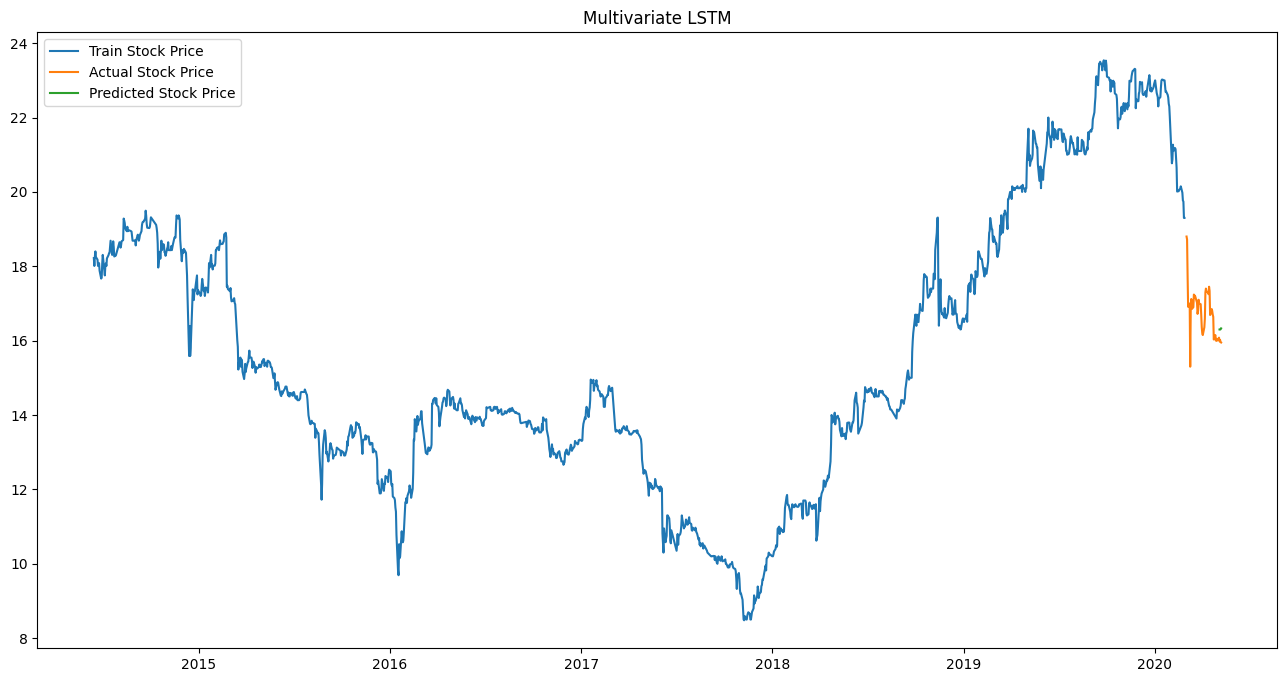

In [31]:
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from matplotlib import dates as mpl_dates

plt.figure(figsize=(16,8))
price_close_train = Y_train[0]
price_close_test = Y_test[0]
plt.plot(train_date, price_close_train, label = "Train Stock Price")
plt.plot(test_date, price_close_test, label = "Actual Stock Price")
plt.plot(pred_date, Y_pred[0], label = "Predicted Stock Price")

plt.title("Multivariate LSTM")
plt.legend(loc='upper left')
#plt.tight_layout()

plt.show()

In [32]:
# Save a model
model.save('MV-LSTM_dataset2_hyperband.h5')